In [1]:
# import os
# print(os.getcwd())
# print(os.listdir())

import quantinfo

import numpy as np
import math, cmath
import time
# from numpy import linalg as LA
from scipy import linalg as LA
import random

import matplotlib.pyplot as plt
import matplotlib




log_negativity = quantinfo.log_negativity
two_qb_cor = quantinfo.two_qb_cor
two_qb_block_vec = quantinfo.two_qb_block_vec
two_qb_block_cor = quantinfo.two_qb_block_cor

# --- Environment's state ---
epsilon = 0.5
b_ee = math.sqrt(1.0/(2.0+epsilon)) + 0j
b_gg = math.sqrt((1.0+epsilon)/(2.0+epsilon)) + 0j
b_eg = math.sqrt(0.0/4.0) + 0j
b_ge = math.sqrt(0.0/4.0) + 0j

if abs(b_ee)**2 + abs(b_eg)**2 + abs(b_gg)**2 + abs(b_ge)**2 < 0.99999:
    print('>>>>> The state of the bath is not normalised.')
coh_scale = 1.0


# --- Coupling strengths ---
lambda1, lambda2 = 1.0e+1, 1.0e+1

# --- time step ---
dt = 1.0e-3
counter = round(100.0/dt)
ntraj = 6000

# --- Dimensionless gammas ---
g1 = (lambda1*dt)**2
g2 = (lambda2*dt)**2


# --- defining lowering (sigma) and rasing operators (sigma^\dagger) ---
s = np.zeros((2,2),dtype=np.float64)
s[1,0]=1

sd = s.conj().T

iden = np.identity(2)

# --- Lindblad operators ---
L1  = np.kron(s,iden)
L2  = np.kron(iden,s)
L1d = np.kron(sd,iden)
L2d = np.kron(iden,sd)


# --- Conditional density matrices ---
rho_c1 = np.zeros((2,2),dtype=np.complex128)
rho_c2 = np.zeros((2,2),dtype=np.complex128)
rho_c = np.kron(rho_c1,rho_c2)



# log_neg = np.zeros(counter+1,dtype=np.float64)
# tq_cor  = np.zeros(counter+1,dtype=np.complex128)
purity_c  = np.zeros((ntraj,counter+1),dtype=np.complex128)

# -----------------------------
#         Bloch vectors  
# -----------------------------
x1_c = np.zeros((ntraj,counter+1),dtype=np.float64)
y1_c = np.zeros((ntraj,counter+1),dtype=np.float64)
z1_c = np.zeros((ntraj,counter+1),dtype=np.float64)
x2_c = np.zeros((ntraj,counter+1),dtype=np.float64)
y2_c = np.zeros((ntraj,counter+1),dtype=np.float64)
z2_c = np.zeros((ntraj,counter+1),dtype=np.float64)



In [ ]:
t_start = time.clock()
# ------------------------------------------------------------------------------------------------
#                                         Quantum trajectories 
#-------------------------------------------------------------------------------------------------
print('--- Trajectory # counter ---')
for k in range(ntraj):
    # ------------------------------------------------
    #      Initial conditional state of the system  MAKE A SWITCH HERE
    # ------------------------------------------------
    
    # --- |ee> ---
    # for i in range(1):
    #     rho_c1[i,i] = 1.0
    #     rho_c2[i,i] = 1.0
    # rho_c = np.kron(rho_c1,rho_c2)
    
    # --- maximally mixed ---
    for i in range(2):
        rho_c1[i,i] = 0.5
        rho_c2[i,i] = 0.5
    rho_c = np.kron(rho_c1,rho_c2)
    
    # --- |++> ---
    # for i in range(2):
    #     for k in range(2):
    #         rho_c1[i,k] = 0.5
    #         rho_c2[i,k] = 0.5
    # rho_c = np.kron(rho_c1,rho_c2)
    
    # --- a|Phi+> + b|Phi-> ---
#     b = 0.8
#     a = math.sqrt(1-b**2)
#     rho_c[0,0] = (a+b)**2/2.0
#     rho_c[3,3] = (a-b)**2/2.0
#     rho_c[0,3] = (a**2-b**2)/2.0
#     rho_c[3,0] = (a**2-b**2)/2.0
    
    purity_c[k,0] = np.trace(rho_c@rho_c)
    x1_c[k,0] = two_qb_block_cor(rho_c)[0]
    y1_c[k,0] = two_qb_block_cor(rho_c)[1]
    z1_c[k,0] = two_qb_block_cor(rho_c)[2]
    x2_c[k,0] = two_qb_block_cor(rho_c)[3]
    y2_c[k,0] = two_qb_block_cor(rho_c)[4]
    z2_c[k,0] = two_qb_block_cor(rho_c)[5]
    
    
    for i in range(counter):
        # -----------------------------------------------------------------------------------------------------
        #     Conditional probabilities (Eqs.(A.3a-d)) 
        #------------------------------------------------------------------------------------------------------
        p_ee = np.real(abs(b_ee)**2 - abs(b_ee)**2 * (g1*np.trace(rho_c@L1@L1d) + g2*np.trace(rho_c@L2@L2d)) \
                   - math.sqrt(g1*g2)*(b_gg*np.conj(b_ee)*np.trace(rho_c@L1@L2) \
                                       + b_ee*np.conj(b_gg)*np.trace(rho_c@L1d@L2d))) 
        p_eg = np.real(g1*abs(b_gg)**2*np.trace(rho_c@L1d@L1) + g2*abs(b_ee)**2*np.trace(rho_c@L2@L2d) \
                   + math.sqrt(g1*g2)*(b_gg*np.conj(b_ee)*np.trace(rho_c@L1@L2) \
                                       + b_ee*np.conj(b_gg)*np.trace(rho_c@L1d@L2d)))
        p_ge = np.real(g1*abs(b_ee)**2*np.trace(rho_c@L1@L1d) + g2*abs(b_gg)**2*np.trace(rho_c@L2d@L2) \
                   + math.sqrt(g1*g2)*(b_gg*np.conj(b_ee)*np.trace(rho_c@L1@L2) \
                                       + b_ee*np.conj(b_gg)*np.trace(rho_c@L1d@L2d)))
        p_gg = np.real(abs(b_gg)**2 - abs(b_gg)**2 * (g1*np.trace(rho_c@L1d@L1) + g2*np.trace(rho_c@L2d@L2)) \
                   - math.sqrt(g1*g2)*(b_gg*np.conj(b_ee)*np.trace(rho_c@L1@L2) \
                                       + b_ee*np.conj(b_gg)*np.trace(rho_c@L1d@L2d)))
        # ---------------------------------------------------------------------------------------------------
        #        Conditional maps 
        #----------------------------------------------------------------------------------------------------
        # make a decision by calling a uniform random number in [0,1].
        rand = random.random()
        if rand <= p_ee:    # Result is |ee>
            rho_c = 1.0/p_ee * (abs(b_ee)**2*rho_c - 0.5*abs(b_ee)**2*(g1*(rho_c@L1@L1d+L1@L1d@rho_c)\
                                                                   +g2*(rho_c@L2@L2d+L2@L2d@rho_c))\
                            -math.sqrt(g1*g2)*(b_gg*np.conj(b_ee)*L1@L2@rho_c + b_ee*np.conj(b_gg)*rho_c@L1d@L2d))
        elif p_ee < rand <= p_ee+p_eg:  # Result is |eg>
            rho_c = 1.0/p_eg * (g1*abs(b_gg)**2*L1@rho_c@L1d + g2*abs(b_ee)**2*L2d@rho_c@L2 \
                            + math.sqrt(g1*g2)*(b_gg*np.conj(b_ee)*L1@rho_c@L2 + b_ee*np.conj(b_gg)*L2d@rho_c@L1d))
        elif p_ee+p_eg < rand <= p_ee+p_eg+p_ge:   # Result is |ge>
            rho_c = 1.0/p_ge * (g1*abs(b_ee)**2*L1d@rho_c@L1 + g2*abs(b_gg)**2*L2@rho_c@L2d \
                            + math.sqrt(g1*g2)*(b_gg*np.conj(b_ee)*L2@rho_c@L1 + b_ee*np.conj(b_gg)*L1d@rho_c@L2d))
        else:   # Result is |gg>
            rho_c = 1/p_gg * (abs(b_gg)**2*rho_c - 0.5*abs(b_gg)**2*(g1*(rho_c@L1d@L1+L1d@L1@rho_c)\
                                                                 +g2*(rho_c@L2d@L2+L2d@L2@rho_c))\
                          -math.sqrt(g1*g2)*(b_gg*np.conj(b_ee)*rho_c@L1@L2 + b_ee*np.conj(b_gg)*L1d@L2d@rho_c))
        purity_c[k,i+1] = np.trace(rho_c@rho_c)
        x1_c[k,i+1] = two_qb_block_cor(rho_c)[0]
        y1_c[k,i+1] = two_qb_block_cor(rho_c)[1]
        z1_c[k,i+1] = two_qb_block_cor(rho_c)[2]
        x2_c[k,i+1] = two_qb_block_cor(rho_c)[3]
        y2_c[k,i+1] = two_qb_block_cor(rho_c)[4]
        z2_c[k,i+1] = two_qb_block_cor(rho_c)[5]
        
    print(k)

(time.clock() - t_start)

In [3]:

# purity  = np.zeros(counter+1,dtype=np.complex128)
x1 = np.zeros(counter+1,dtype=np.float64)
y1 = np.zeros(counter+1,dtype=np.float64)
z1 = np.zeros(counter+1,dtype=np.float64)
x2 = np.zeros(counter+1,dtype=np.float64)
y2 = np.zeros(counter+1,dtype=np.float64)
z2 = np.zeros(counter+1,dtype=np.float64)
for k in range(counter+1):
    x1[k] = np.mean(x1_c[:,k])
    y1[k] = np.mean(y1_c[:,k])
    z1[k] = np.mean(z1_c[:,k])
    x2[k] = np.mean(x2_c[:,k])
    y2[k] = np.mean(y2_c[:,k])
    z2[k] = np.mean(z2_c[:,k])
#     purity[k] = np.mean(purity_c[:,k])

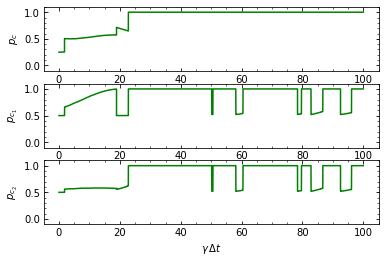

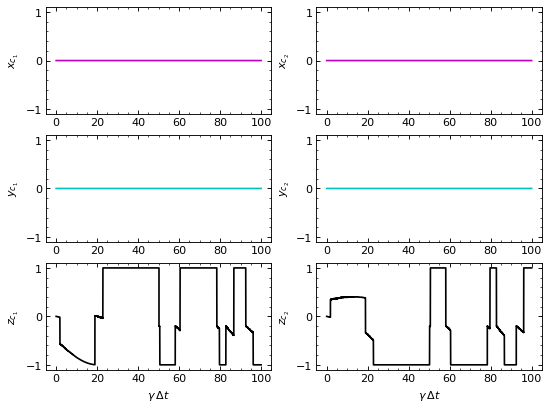

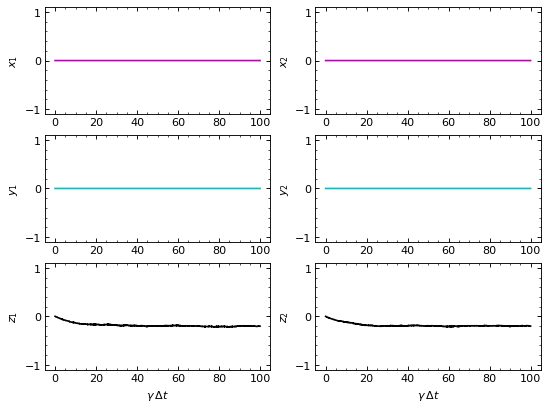

In [7]:
traj_tag = 9
time_win = np.arange(0,np.size(purity_c[traj_tag]))*dt
# np.savetxt('coh_bath.txt',log_neg)

# plt.figure(1,figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
# plt.subplot(311)
# plt.plot(time,log_neg,'r--')
# plt.xlabel('')
# plt.ylabel('LN')
# plt.ylim((-0.1,1.1))
# plt.minorticks_on()
# plt.tick_params(axis='both', which='both', direction='in',bottom=True, top=True, left=True, right=True)

# plt.figure(1,figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
# plt.subplot(312)
# plt.plot(time,np.real(tq_cor),'b')
# plt.xlabel('')
# plt.ylabel('$T^2$')
# plt.ylim((-0.1,1.1))
# plt.minorticks_on()
# plt.tick_params(axis='both', which='both', direction='in',bottom=True, top=True, left=True, right=True)



# plt.subplot(313)
# plt.plot(time_win,np.real(purity),'g')
# plt.xlabel('$\gamma\,\Delta t$')
# plt.ylabel('$p$')
# plt.ylim((-0.1,1.1))
# plt.minorticks_on()
# plt.tick_params(axis='both', which='both', direction='in',bottom=True, top=True, left=True, right=True)

# plt.savefig('pur_joint.pdf')
# plt.show()

# --- plotting conditional purities ---

plt.subplot(311)
plt.plot(time_win,np.real(purity_c[traj_tag]),'g')
plt.xlabel('$\gamma\,\Delta t$')
plt.ylabel('$p_c$')
plt.ylim((-0.1,1.1))
plt.minorticks_on()
plt.tick_params(axis='both', which='both', direction='in',bottom=True, top=True, left=True, right=True)

plt.subplot(312)
plt.plot(time_win,0.5*(1.0+x1_c[traj_tag]**2+y1_c[traj_tag]**2+z1_c[traj_tag]**2),'g')
plt.xlabel('$\gamma\,\Delta t$')
plt.ylabel('$p_{c_1}$')
plt.ylim((-0.1,1.1))
plt.minorticks_on()
plt.tick_params(axis='both', which='both', direction='in',bottom=True, top=True, left=True, right=True)

plt.subplot(313)
plt.plot(time_win,0.5*(1.0+x2_c[traj_tag]**2+y2_c[traj_tag]**2+z2_c[traj_tag]**2),'g')
plt.xlabel('$\gamma\,\Delta t$')
plt.ylabel('$p_{c_2}$')
plt.ylim((-0.1,1.1))
plt.minorticks_on()
plt.tick_params(axis='both', which='both', direction='in',bottom=True, top=True, left=True, right=True)

plt.savefig('pur_c.pdf')
plt.show()



# --- plotting conditional Bloch vectors ---

plt.figure(2,figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(321)
plt.plot(time_win,x1_c[traj_tag],'m')
plt.xlabel('')
plt.ylabel('$x_{c_1}$')
plt.ylim((-1.1,1.1))
plt.minorticks_on()
plt.tick_params(axis='both', which='both', direction='in',bottom=True, top=True, left=True, right=True)

plt.figure(2,figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(323)
plt.plot(time_win,y1_c[traj_tag],'c')
plt.xlabel('')
plt.ylabel('$y_{c_1}$')
plt.ylim((-1.1,1.1))
plt.minorticks_on()
plt.tick_params(axis='both', which='both', direction='in',bottom=True, top=True, left=True, right=True)

plt.figure(2,figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(325)
plt.plot(time_win,z1_c[traj_tag],'k')
plt.xlabel('$\gamma\,\Delta t$')
plt.ylabel('$z_{c_1}$')
plt.ylim((-1.1,1.1))
plt.minorticks_on()
plt.tick_params(axis='both', which='both', direction='in',bottom=True, top=True, left=True, right=True)

plt.figure(2,figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(322)
plt.plot(time_win,x2_c[traj_tag],'m')
plt.xlabel('')
plt.ylabel('$x_{c_2}$')
plt.ylim((-1.1,1.1))
plt.minorticks_on()
plt.tick_params(axis='both', which='both', direction='in',bottom=True, top=True, left=True, right=True)

plt.figure(2,figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(324)
plt.plot(time_win,y2_c[traj_tag],'c')
plt.xlabel('')
plt.ylabel('$y_{c_2}$')
plt.ylim((-1.1,1.1))
plt.minorticks_on()
plt.tick_params(axis='both', which='both', direction='in',bottom=True, top=True, left=True, right=True)

plt.figure(2,figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(326)
plt.plot(time_win,z2_c[traj_tag],'k')
plt.xlabel('$\gamma\,\Delta t$')
plt.ylabel('$z_{c_2}$')
plt.ylim((-1.1,1.1))
plt.minorticks_on()
plt.tick_params(axis='both', which='both', direction='in',bottom=True, top=True, left=True, right=True)

plt.savefig('bloch_vecs_c.pdf')
plt.show()


# --- plotting Bloch vectors ---

plt.figure(3,figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(321)
plt.plot(time_win,x1,'m')
plt.xlabel('')
plt.ylabel('$x_1$')
plt.ylim((-1.1,1.1))
plt.minorticks_on()
plt.tick_params(axis='both', which='both', direction='in',bottom=True, top=True, left=True, right=True)

plt.figure(3,figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(323)
plt.plot(time_win,y1,'c')
plt.xlabel('')
plt.ylabel('$y_1$')
plt.ylim((-1.1,1.1))
plt.minorticks_on()
plt.tick_params(axis='both', which='both', direction='in',bottom=True, top=True, left=True, right=True)

plt.figure(3,figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(325)
plt.plot(time_win,z1,'k')
plt.xlabel('$\gamma\,\Delta t$')
plt.ylabel('$z_1$')
plt.ylim((-1.1,1.1))
plt.minorticks_on()
plt.tick_params(axis='both', which='both', direction='in',bottom=True, top=True, left=True, right=True)

plt.figure(3,figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(322)
plt.plot(time_win,x2,'m')
plt.xlabel('')
plt.ylabel('$x_2$')
plt.ylim((-1.1,1.1))
plt.minorticks_on()
plt.tick_params(axis='both', which='both', direction='in',bottom=True, top=True, left=True, right=True)

plt.figure(3,figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(324)
plt.plot(time_win,y2,'c')
plt.xlabel('')
plt.ylabel('$y_2$')
plt.ylim((-1.1,1.1))
plt.minorticks_on()
plt.tick_params(axis='both', which='both', direction='in',bottom=True, top=True, left=True, right=True)

plt.figure(3,figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(326)
plt.plot(time_win,z2,'k')
plt.xlabel('$\gamma\,\Delta t$')
plt.ylabel('$z_2$')
plt.ylim((-1.1,1.1))
plt.minorticks_on()
plt.tick_params(axis='both', which='both', direction='in',bottom=True, top=True, left=True, right=True)


plt.savefig('bloch_vecs.pdf')
plt.show()

np.savetxt('pc.txt',np.real(purity_c[traj_tag]))
np.savetxt('pc1.txt',0.5*(1.0+x1_c[traj_tag]**2+y1_c[traj_tag]**2+z1_c[traj_tag]**2))
np.savetxt('pc2.txt',0.5*(1.0+x2_c[traj_tag]**2+y2_c[traj_tag]**2+z2_c[traj_tag]**2))
np.savetxt('x1_c.txt',x1_c[traj_tag])
np.savetxt('y1_c.txt',y1_c[traj_tag])
np.savetxt('z1_c.txt',z1_c[traj_tag])
np.savetxt('x2_c.txt',x2_c[traj_tag])
np.savetxt('y2_c.txt',y2_c[traj_tag])
np.savetxt('z2_c.txt',z2_c[traj_tag])
np.savetxt('x1.txt',x1)
np.savetxt('y1.txt',y1)
np.savetxt('z1.txt',z1)
np.savetxt('x2.txt',x2)
np.savetxt('y2.txt',y2)
np.savetxt('z2.txt',z2)

In [ ]:
print(traj_tag)
np.set_printoptions(precision=8)
print(np.size(np.real(purity_c[traj_tag])))
print(np.size(1+x1_c[traj_tag]))
print(np.real(purity_c[traj_tag])[3])